In [3]:
import csv
import os
import pandas as pd
import numpy as np
from tensorflow import keras
from math import sqrt
from numpy import concatenate
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers
from pandas import DataFrame
from pandas import concat
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU
from tensorflow.keras import losses
import tensorflow.keras.backend as K
from tensorflow.keras import regularizers
from tensorflow.keras.models import Model
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Input, Conv1D, Reshape, Lambda, Flatten, Concatenate
from tensorflow.keras.layers import Layer, Dense, LSTM, Activation, Multiply, Add, Dropout, Dot
os.environ["CUDA_VISIBLE_DEVICES"]="0" 

In [4]:
def DataRead(Dicti, HEADER = None, NAMES = None):
    f1 = pd.read_csv(Dicti, header=HEADER, names =NAMES)
    f2 = np.array(f1)
    return f2

def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual) # 用均值代替真实值0
    return res

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred)))) * 100

def mean_absolute_error(y_true, y_pred): 
    return np.mean(np.abs(y_true - y_pred))

def mean_squared_error(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# 转换序列成监督学习问题，构造时序数列输入格式
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

class CalculateScoreMatrix(Layer):
    def __init__(self, output_dim=None, **kwargs):
        self.output_dim = output_dim
        super(CalculateScoreMatrix, self).__init__(**kwargs)
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({'output_dim': self.output_dim})
        return config
    
    def build(self, input_shape):
        self.kernel = self.add_weight(name='kernel',
                                          shape=(input_shape[-1], self.output_dim),
                                          initializer='uniform',
                                          trainable=True)
        super(CalculateScoreMatrix, self).build(input_shape)
        
    def call(self, x):
        res = K.dot(x, self.kernel)
        return res

In [5]:
Data_EP_dict = r"C:\Users\think\Desktop\区块链下群体智能定价\hvacdata.csv"
Data_EP = DataRead(Data_EP_dict, 0)

Data_input_EP = Data_EP[:,1:7]
Data_input_EP = Data_input_EP.astype(np.float64)

Scaler_temp_1 = StandardScaler()
Scaler_temp_2 = StandardScaler()
Scaler_humid_1 = StandardScaler()
Scaler_humid_2 = StandardScaler()
Scaler_wind_1 = StandardScaler()
Scaler_wind_2 = StandardScaler()

Data_input_EP[:,0] = Scaler_temp_1.fit_transform(Data_input_EP[:,0].reshape(-1,1)).reshape(-1)
Data_input_EP[:,1] = Scaler_temp_2.fit_transform(Data_input_EP[:,1].reshape(-1,1)).reshape(-1)
Data_input_EP[:,2] = Scaler_humid_1.fit_transform(Data_input_EP[:,2].reshape(-1,1)).reshape(-1)
Data_input_EP[:,3] = Scaler_humid_2.fit_transform(Data_input_EP[:,3].reshape(-1,1)).reshape(-1)
Data_input_EP[:,4] = Scaler_wind_1.fit_transform(Data_input_EP[:,4].reshape(-1,1)).reshape(-1)
Data_input_EP[:,5] = Scaler_wind_2.fit_transform(Data_input_EP[:,5].reshape(-1,1)).reshape(-1)

Data_input_EP = Data_input_EP.T.reshape([Data_input_EP.shape[-1],int(Data_EP.shape[-2]/24),24])
print(Data_input_EP.shape)
Data_output_EP = np.sum(Data_EP[:,7:], axis = 1)
Data_output_EP = Data_output_EP.reshape([int(Data_EP.shape[-2]/24),24])
Data_output_EP = Data_output_EP.astype(np.float64)
Data_output_EP = Data_output_EP
print(Data_output_EP.shape)

(6, 730, 24)
(730, 24)


In [6]:
AppData_Dict = r"C:\Users\think\Desktop\区块链下群体智能定价\Load"
Price_Dict = r"C:\Users\think\Desktop\区块链下群体智能定价\price730.csv"
AppDataFileName = os.listdir(AppData_Dict)
App_list = {}

Price = DataRead(Price_Dict,None)

CreateNames = locals()
for i in range(len(AppDataFileName)):
    shotname,extension = os.path.splitext(AppDataFileName[i])
    App_list["App_" + str(shotname)]=DataRead(os.path.join(AppData_Dict, AppDataFileName[i]),None)
    CreateNames["App_" + str(shotname)] = DataRead(os.path.join(AppData_Dict, AppDataFileName[i]),None)

Subject_App_all = np.zeros([Price.shape[0], Price.shape[1]])

for Subject_App_name, Subject_App in App_list.items():
    Subject_App_all = Subject_App_all + Subject_App

Subject_App_all = Subject_App_all + 1

Data_output = Data_output_EP + Subject_App_all
Data_output.shape

(730, 24)

In [7]:
Train_size = 0.8
Validation_size = 0.9
Timestep = 7
N_out = 1
Time_number = Price.shape[-1]

Scaler_price = StandardScaler()
Price = Price.reshape(-1)
Price = Scaler_price.fit_transform(Price.astype(np.float64).reshape(-1,1))
Price = Price.reshape((int(Price.shape[0]/Time_number),Time_number))


Data_input_load = series_to_supervised(Data_output, Timestep - 1, N_out)
#print(Data_input_load)
Data_input_load = Data_input_load.values
Data_input_load = Data_input_load[:-1,:]
Data_number = Data_input_load.shape[0]

Data_input_price = Price[Timestep:,:]

Data_input_EP, Data_output = Data_input_EP[:,Timestep:,:], Data_output[Timestep:,:]


Data_input_load_train = Data_input_load[:int(Data_number*Train_size),:]
Data_input_price_train = Data_input_price[:int(Data_number*Train_size),:]
Data_input_EP_train = Data_input_EP[:,:int(Data_number*Train_size),:]
Data_output_train = Data_output[:int(Data_number*Train_size),:]
print(Data_output_train.shape)

Data_input_load_validation = Data_input_load[int(Data_number*Train_size):int(Data_number*Validation_size),:]
Data_input_price_validation = Data_input_price[int(Data_number*Train_size):int(Data_number*Validation_size),:]
Data_input_EP_validation = Data_input_EP[:,int(Data_number*Train_size):int(Data_number*Validation_size),:]
Data_output_validation = Data_output[int(Data_number*Train_size):int(Data_number*Validation_size),:]
print(Data_output_validation.shape)

Data_input_load_test = Data_input_load[int(Data_number*Validation_size):,:]
Data_input_price_test = Data_input_price[int(Data_number*Validation_size):,:]
Data_input_EP_test = Data_input_EP[:,int(Data_number*Validation_size):,:]
Data_output_test = Data_output[int(Data_number*Validation_size):,:]
print(Data_output_test.shape)

Data_input_load_train = Data_input_load_train.reshape((Data_input_load_train.shape[0], Timestep, Price.shape[-1]))
Data_input_load_validation = Data_input_load_validation.reshape((Data_input_load_validation.shape[0], Timestep, Price.shape[-1]))
Data_input_load_test = Data_input_load_test.reshape((Data_input_load_test.shape[0], Timestep, Price.shape[-1]))

Train_number = Data_input_price_train.shape[0]
Validation_number = Data_input_price_validation.shape[0]
Test_number = Data_input_price_test.shape[0]

(578, 24)
(72, 24)
(73, 24)


In [8]:
Data_input_train = [Data_input_price_train, Data_input_load_train,
                    Data_input_EP_train[0,:,:], Data_input_load_train,
                    Data_input_EP_train[1,:,:], Data_input_load_train,
                    Data_input_EP_train[2,:,:], Data_input_load_train,
                    Data_input_EP_train[3,:,:], Data_input_load_train,
                    Data_input_EP_train[4,:,:], Data_input_load_train,
                    Data_input_EP_train[5,:,:], Data_input_load_train,
                   Data_input_load_train]
Data_input_validation = [Data_input_price_validation, Data_input_load_validation,
                          Data_input_EP_validation[0,:,:], Data_input_load_validation,
                          Data_input_EP_validation[1,:,:], Data_input_load_validation,
                          Data_input_EP_validation[2,:,:], Data_input_load_validation,
                          Data_input_EP_validation[3,:,:], Data_input_load_validation,
                          Data_input_EP_validation[4,:,:], Data_input_load_validation,
                          Data_input_EP_validation[5,:,:], Data_input_load_validation,
                        Data_input_load_validation]
Data_input_test = [Data_input_price_test, Data_input_load_test,
                    Data_input_EP_test[0,:,:], Data_input_load_test,
                    Data_input_EP_test[1,:,:], Data_input_load_test,
                    Data_input_EP_test[2,:,:], Data_input_load_test,
                    Data_input_EP_test[3,:,:], Data_input_load_test,
                    Data_input_EP_test[4,:,:], Data_input_load_test,
                    Data_input_EP_test[5,:,:], Data_input_load_test,
                  Data_input_load_test]

print(Data_input_price_train.shape)
print(Data_input_load_train.shape)
print(Data_input_load_test.shape)

(578, 24)
(578, 7, 24)
(73, 7, 24)


In [9]:
import tensorflow as tf
import random
def seed_tensorflow(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)


In [10]:
from tensorflow.keras.models import load_model
from attention import Attention
seed_tensorflow()
MixedModelWithoutAttention = load_model('MixedModelWithoutAttention.h5',custom_objects={'CalculateScoreMatrix':CalculateScoreMatrix})
MixedModelWithoutAttention.fit(x=Data_input_train,y=Data_output_train,validation_data=Data_input_validation,epochs=100,shuffle=False)
MixedModelWithAttention = load_model('MixedModelWithAttention.h5',custom_objects={'Attention':Attention, 'CalculateScoreMatrix':CalculateScoreMatrix})
MixedModelWithAttention.fit(x=Data_input_train,y=Data_output_train,validation_data=Data_input_validation,epochs=100,shuffle=False)

Epoch 1/100
19/19 [==============================] - 4s 191ms/step - loss: 12.8016 - val_loss: 0.0000e+00
Epoch 2/100
19/19 [==============================] - 1s 49ms/step - loss: 8.3962 - val_loss: 0.0000e+00
Epoch 3/100
19/19 [==============================] - 1s 67ms/step - loss: 7.0810 - val_loss: 0.0000e+00
Epoch 4/100
19/19 [==============================] - 1s 61ms/step - loss: 5.8159 - val_loss: 0.0000e+00
Epoch 5/100
19/19 [==============================] - 1s 46ms/step - loss: 5.0198 - val_loss: 0.0000e+00
Epoch 6/100
19/19 [==============================] - 1s 49ms/step - loss: 4.6283 - val_loss: 0.0000e+00
Epoch 7/100
19/19 [==============================] - 1s 36ms/step - loss: 4.2896 - val_loss: 0.0000e+00
Epoch 8/100
19/19 [==============================] - 0s 15ms/step - loss: 4.0532 - val_loss: 0.0000e+00
Epoch 9/100
19/19 [==============================] - 0s 15ms/step - loss: 3.8113 - val_loss: 0.0000e+00
Epoch 10/100
19/19 [==============================] - 0s 15ms/

In [11]:
import time
start1 = time.process_time()
Predictions1 = MixedModelWithoutAttention.predict(Data_input_test)
end1 = time.process_time()
print((end1 - start1)/Predictions1.shape[0])
start2 = time.process_time()
Predictions2 = MixedModelWithAttention.predict(Data_input_test)
end2 = time.process_time()
print((end2 - start2)/Predictions2.shape[0])

Predictions1 = Predictions1.reshape(-1,1)
Predictions2 = Predictions2.reshape(-1,1)
Data_output_test_reshape = Data_output_test.reshape(-1,1)


mape_TPA1 = mean_absolute_percentage_error(Data_output_test_reshape, Predictions1)
print("WithoutAttention MAPE is: ", mape_TPA1, "%")
mape_TPA2 = mean_absolute_percentage_error(Data_output_test_reshape, Predictions2)
print("WithAttention MAPE is: ", mape_TPA2, "%")
mae_TPA1 = mean_absolute_error(Data_output_test_reshape, Predictions1)
print("WithoutAttention MAE is: ", mae_TPA1)
mae_TPA2 = mean_absolute_error(Data_output_test_reshape, Predictions2)
print("WithAttention MAE is: ", mae_TPA2)
rmse_TPA1 = root_mean_squared_error(Data_output_test_reshape, Predictions1)
print("WithoutAttention RMSE is: ", rmse_TPA1)
rmse_TPA2 = root_mean_squared_error(Data_output_test_reshape, Predictions2)
print("WithAttention RMSE is: ", rmse_TPA2)

0.016481164383561644
0.01776541095890411
WithoutAttention MAPE is:  29.03260391953998 %
WithAttention MAPE is:  27.604968951885866 %
WithoutAttention MAE is:  1.0626021407659318
WithAttention MAE is:  0.9626105413016784
WithoutAttention RMSE is:  1.6341309561078117
WithAttention RMSE is:  1.4789499143990579


In [36]:
#import matplotlib as mpl
#mpl.rcParams.update(mpl.rcParamsDefault)

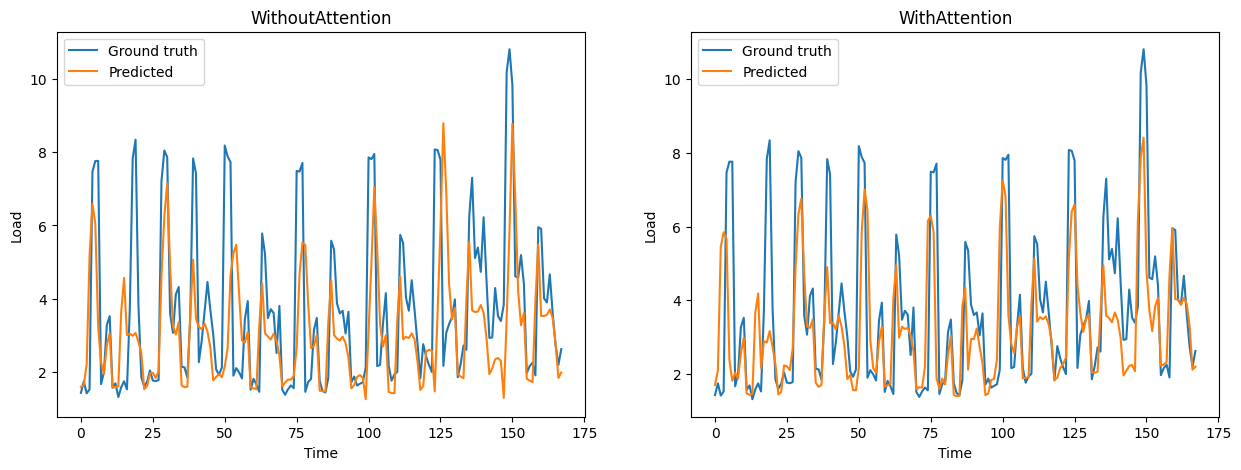

In [12]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(Data_output_test_reshape[-24*7:], label='Ground truth')
plt.plot(Predictions1[-24*7:], label='Predicted')
plt.title('WithoutAttention')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Load')
plt.subplot(1,2,2)
plt.plot(Data_output_test_reshape[-24*7:], label='Ground truth')
plt.plot(Predictions2[-24*7:], label='Predicted')
plt.title('WithAttention')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Load')
plt.show()

In [70]:
Evaluated_data1 = np.array([Data_output_test_reshape.reshape(-1), Predictions1.reshape(-1)])
Evaluated_data2 = np.array([Data_output_test_reshape.reshape(-1), Predictions2.reshape(-1)])
print(Evaluated_data1.shape)
print(Evaluated_data2.shape)

(2, 1752)
(2, 1752)


In [12]:
#with open('ProposedModelWithoutAttention.csv','w')as f:
    #f_csv = csv.writer(f)
    #f_csv.writerows(Evaluated_data1)
    #f_csv.writerows(Evaluated_data2)